In [1]:
!pip install plotly --upgrade
!pip install statsmodels
!pip install scipy

### Also run, `conda install scipy`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Retailrocket recommender system dataset

Source: https://www.kaggle.com/retailrocket/ecommerce-dataset

Load the dataset files.

In [3]:
events = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'events.csv'))
item_properties = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'item_properties_part1.csv'))
category_tree = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'category_tree.csv'))

In [4]:
events

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


In [5]:
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [6]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


## Exploratory Data Analysis (EDA)

EDA is about understanding the data and forming hypotheses about it. 

- Visualizing Data: Histograms, scatter plots, box plots, etc., to understand distributions and relationships.
- Summary Statistics: Calculating mean, median, mode, standard deviation, and correlation to gain insights into the dataset.
- Detecting Outliers: Identifying values that deviate significantly from the rest of the data.
- Assessing Data Types and Structure: Checking data types, unique values, and identifying missing values.

In [7]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events['event_date'] = events['event_datetime'].dt.date

In [8]:
grouped_events = events.groupby(['event_date', 'itemid', 'event']).size().\
                                reset_index(name='event_count')
grouped_events

,event_date,itemid,event,event_count
0,2015-05-03,16,view,1
1,2015-05-03,19,view,1
2,2015-05-03,32,view,1
3,2015-05-03,33,addtocart,1
4,2015-05-03,33,view,1
...,...,...,...,...
1743097,2015-09-18,464474,view,2
1743098,2015-09-18,464538,view,1
1743099,2015-09-18,465387,view,1
1743100,2015-09-18,466321,view,1


#### Q1: Compute top 10 items with the highest number of `view` events.

In [9]:
grouped_events['event'] == 'view'

0           True
1           True
2           True
3          False
4           True
           ...  
1743097     True
1743098     True
1743099     True
1743100     True
1743101     True
Name: event, Length: 1743102, dtype: bool

In [10]:
top_view_items = grouped_events[grouped_events['event'] == 'view'].\
                    sort_values(by='event_count', ascending=False).head(10)
top_view_items

,event_date,itemid,event,event_count
440229,2015-06-06,5411,view,333
489069,2015-06-10,5411,view,303
1103845,2015-07-26,149275,view,300
474561,2015-06-09,5411,view,272
276694,2015-05-24,290250,view,251
1714225,2015-09-15,17114,view,248
993175,2015-07-18,115323,view,234
238643,2015-05-21,211811,view,216
1725707,2015-09-15,434782,view,198
1208429,2015-08-03,162139,view,166


#### Q2: What is the distribution of event types (view, transaction, etc.) in the events dataset?

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


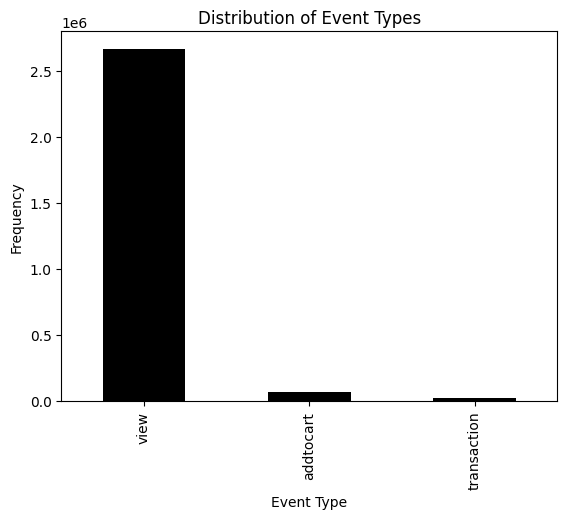

In [11]:
event_type_counts = events['event'].value_counts()
print(event_type_counts)

event_type_counts.plot(kind='bar', color='black')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.show()

#### Q3: How many different items are in the dataset?

In [12]:
unique_items = events['itemid'].nunique()
unique_items

235061

#### Q4: What is the average number of events per visitor?

In [13]:
events_per_visitor = events.groupby('visitorid').size()
avg_events_per_visitor = events_per_visitor.mean()
avg_events_per_visitor

np.float64(1.9580421716705267)

#### Q5: How many unique transactions are in the dataset?

In [14]:
unique_transactions = events['transactionid'].nunique()
unique_transactions

17672

#### Q6: What is the distribution of transactions?

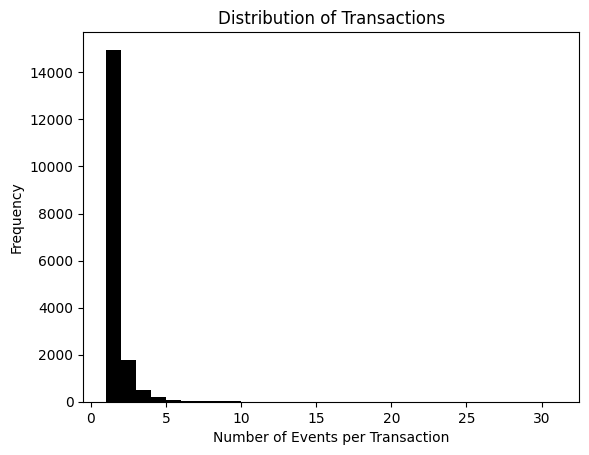

In [15]:
transaction_counts = events[events['transactionid'].notnull()]\
                        ['transactionid'].value_counts()

transaction_counts.plot(kind='hist', bins=30, color='black')
plt.title('Distribution of Transactions')
plt.xlabel('Number of Events per Transaction')
plt.ylabel('Frequency')
plt.show()

#### Q7: How many events happen on average per day?

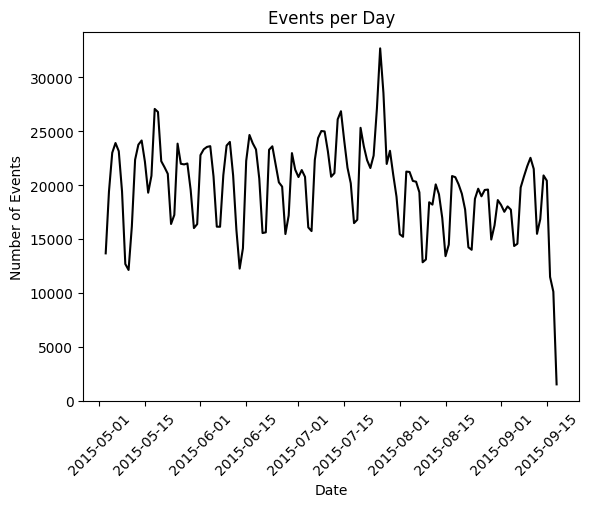

In [16]:
events_per_day = events.groupby(events['event_date']).size()

avg_events_per_day = events_per_day.mean()

events_per_day.plot(kind='line', title='Events per Day', color='black')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()

#### Q8: Convert `parentid` column to `int32` type.

In [17]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


In [18]:
category_tree_v2 = category_tree.copy()
category_tree_v3 = category_tree.copy()
category_tree_v4 = category_tree.copy()

In [19]:
category_tree_v2.parentid = category_tree_v2.parentid.astype("int32")
category_tree_v2

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

## Data imputation

a process that replaces missing values in a dataset with substituted values

### Handling missing values with `category_tree`

#### Option 1: Fill `NaN` with a placeholder value (e.g., -1 or another integer)

In [20]:
category_tree_v2['parentid'] = category_tree['parentid'].fillna(-1).astype("int32")
category_tree_v2

,categoryid,parentid
0,1016,213
1,809,169
2,570,9
3,1691,885
4,536,1691
...,...,...
1664,49,1125
1665,1112,630
1666,1336,745
1667,689,207


#### Option 2: Drop rows with `NaN` in the `parentid `column

In [21]:
category_tree_v3 = category_tree_v3.dropna(subset=['parentid'])

category_tree_v3.parentid = category_tree_v3.parentid.astype("int32")
category_tree_v3

,categoryid,parentid
0,1016,213
1,809,169
2,570,9
3,1691,885
4,536,1691
...,...,...
1664,49,1125
1665,1112,630
1666,1336,745
1667,689,207


#### Option 3: Use `Int32` (nullable integer type)

In [22]:
category_tree_v4['parentid'] = category_tree_v4['parentid'].astype("Int32")
category_tree_v4

,categoryid,parentid
0,1016,213
1,809,169
2,570,9
3,1691,885
4,536,1691
...,...,...
1664,49,1125
1665,1112,630
1666,1336,745
1667,689,207


### Other options for Data Imputation

- Next or previous value
- Maximum or Minimum Value
- Statistical methods: mean, median, mode
- Missing Value Prediction: using a machine learning model to determine the final imputation value

Replace with next value.

In [23]:
np.random.seed(639)

date_range = pd.date_range(start='2024-01-01', periods=15, freq='D')
sales_data = np.random.normal(loc=200, scale=20, size=len(date_range))
sales_data[::5] = np.nan  # missing value every 5th day

df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.bfill()
print(df)

         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06         NaN
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11         NaN
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833
         date       sales
0  2024-01-01  161.315284
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06  212.835380
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11  207.302194
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833


Replace with previous value.

In [24]:
df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.ffill()
print(df)

         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06         NaN
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11         NaN
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833
         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06  187.461438
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11  209.238439
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833


Replace with minimum / maximum.

In [25]:
df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.fillna(df.sales.min()) # or max() for maximum
print(df)

         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06         NaN
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11         NaN
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833
         date       sales
0  2024-01-01  161.315284
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06  161.315284
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11  161.315284
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833


Replace with mean.

In [26]:
df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.fillna(df.sales.mean())
print(df)

         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06         NaN
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11         NaN
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833
         date       sales
0  2024-01-01  204.786344
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06  204.786344
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11  204.786344
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833


Replace with median.

In [27]:
df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.fillna(df.sales.median())
print(df)

         date       sales
0  2024-01-01         NaN
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06         NaN
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11         NaN
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833
         date       sales
0  2024-01-01  208.270316
1  2024-01-02  161.315284
2  2024-01-03  209.515871
3  2024-01-04  261.218322
4  2024-01-05  187.461438
5  2024-01-06  208.270316
6  2024-01-07  212.835380
7  2024-01-08  210.293946
8  2024-01-09  188.743735
9  2024-01-10  209.238439
10 2024-01-11  208.270316
11 2024-01-12  207.302194
12 2024-01-13  174.204051
13 2024-01-14  200.503635
14 2024-01-15  234.803833


Replace with mode.

In [28]:
np.random.seed(639)

date_range = pd.date_range(start='2024-01-01', periods=15, freq='D')
values = [100, 150, 200, 250]
sales_data = np.random.choice(values, size=15).tolist()

for i in range(0, len(sales_data), 5):
    sales_data[i] = np.nan

df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df)

df = df.fillna(df.sales.mode().iloc[0])
print(df)

         date  sales
0  2024-01-01    NaN
1  2024-01-02  200.0
2  2024-01-03  150.0
3  2024-01-04  150.0
4  2024-01-05  200.0
5  2024-01-06    NaN
6  2024-01-07  250.0
7  2024-01-08  150.0
8  2024-01-09  150.0
9  2024-01-10  150.0
10 2024-01-11    NaN
11 2024-01-12  150.0
12 2024-01-13  200.0
13 2024-01-14  200.0
14 2024-01-15  200.0
         date  sales
0  2024-01-01  150.0
1  2024-01-02  200.0
2  2024-01-03  150.0
3  2024-01-04  150.0
4  2024-01-05  200.0
5  2024-01-06  150.0
6  2024-01-07  250.0
7  2024-01-08  150.0
8  2024-01-09  150.0
9  2024-01-10  150.0
10 2024-01-11  150.0
11 2024-01-12  150.0
12 2024-01-13  200.0
13 2024-01-14  200.0
14 2024-01-15  200.0


### Data Interpolation

Interpolation is a technique that can be useful for handling missing values, particularly when the missing data is assumed to follow a pattern or trend based on the existing values in the dataset. This is often the case with time series or ordered data, where the missing values are assumed to lie between known values. Interpolation fills in these gaps by estimating the missing data points using existing values.

When **NOT** to Use Interpolation:
- Large gaps: If the data has large gaps between observations, interpolation might not provide meaningful or reliable estimates.
- Randomness in missing values: If the missing values are random or don't follow any pattern (Missing Completely at Random - MCAR), interpolation may not be appropriate, as it assumes a relationship between values.
- Categorical or non-numeric data: Interpolation is typically used for continuous numerical data. For categorical or binary data, interpolation is not suitable.

        date       sales
0 2024-01-01         NaN
1 2024-01-02  161.315284
2 2024-01-03  209.515871
3 2024-01-04  261.218322
4 2024-01-05  187.461438


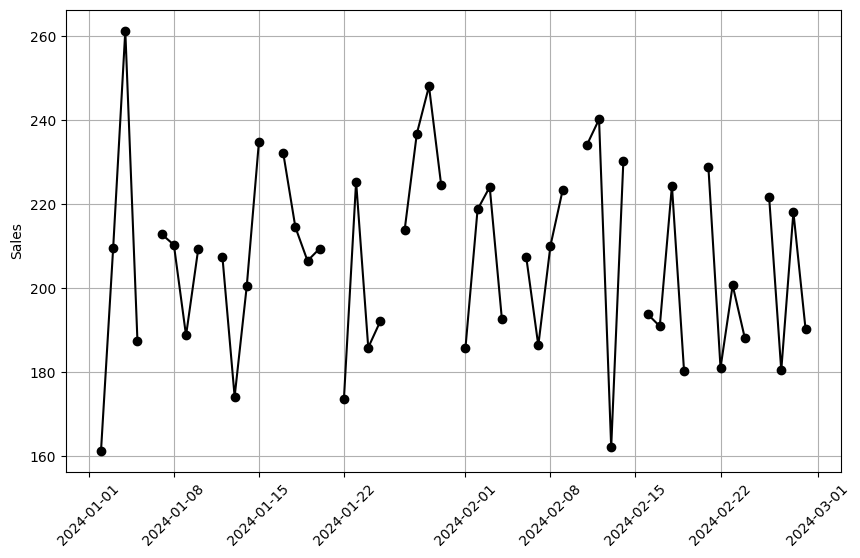

In [29]:
np.random.seed(639)

date_range = pd.date_range(start='2024-01-01', periods=60, freq='D')
sales_data = np.random.normal(loc=200, scale=20, size=len(date_range))
sales_data[::5] = np.nan  # missing value every 5th day

df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})
print(df.head())

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], marker='o', linestyle='-', color='black')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### Linear interpolation

- Assumption: the missing data points lie along a straight line between the known data points.
- Linear interpolation commonly used for time series where changes are expected to be linear between data points.
- When to use: when the relationship between consecutive values is roughly linear or changes gradually.

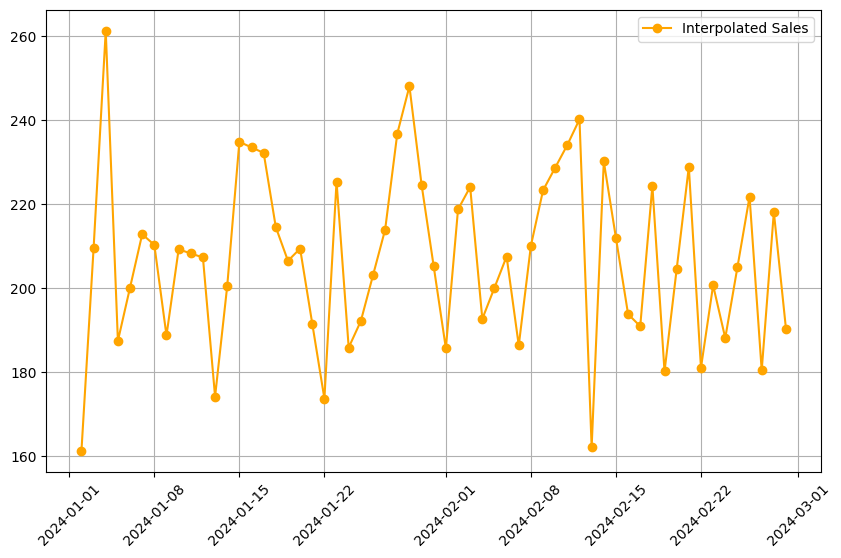

In [30]:
df['sales'] = df['sales'].interpolate(method='linear')

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], marker='o', linestyle='-', label='Interpolated Sales', color='orange')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### Polynomial interpolation

- Polynomial interpolation fits a polynomial curve through the known data points and uses it to estimate the missing values.
- When to use: when the data shows a nonlinear relationship between points (for example, seasonal effects or periodic patterns).

In [31]:
df['sales'] = df['sales'].interpolate(method='polynomial', order=2)

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], marker='o', linestyle='-', label='Interpolated Sales', color='orange')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

ImportError: Missing optional dependency 'scipy'. polynomial interpolation requires SciPy. Use pip or conda to install scipy.

#### Why do both methods produced the same result?

- Polynomial interpolation of order 2 fits a quadratic function (a parabola) between the two surrounding data points.
- A quadratic function can curve, but for the simple case where the data points are relatively close to each other and do not exhibit any highly nonlinear or curving behavior, the quadratic curve might end up being very similar to the straight line in terms of interpolation.
- When there are only two points surrounding the missing value (as is typical with simple time series data), the quadratic interpolation will essentially behave like a linear interpolation because a second-degree polynomial (a parabola) that passes through two points is uniquely determined by those two points and does not "bend" between them in a noticeable way.

In [ ]:
# Non-linear timeseries - sine curve
np.random.seed(42)
date_range = pd.date_range(start='2024-01-01', periods=60, freq='D')
sales_data = 100 + 50 * np.sin(np.linspace(0, 3 * np.pi, len(date_range)))

# Introduce missing values randomly
missing_indices = np.random.choice(range(len(sales_data)), size=18, replace=False)
sales_data[missing_indices] = np.nan

df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], marker='o', linestyle='-', label='Original Sales with Missing Values')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.grid(True)

In [ ]:
# Interpolate using linear method
df['sales_linear'] = df['sales'].interpolate(method='linear')

# Interpolate using polynomial method (order 2)
df['sales_polynomial'] = df['sales'].interpolate(method='polynomial', order=2)

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales_linear'], marker='o', linestyle='-', label='Interpolated Sales (Linear)', color='orange')
plt.plot(df['date'], df['sales_polynomial'], marker='x', linestyle='-', label='Interpolated Sales (Polynomial)', color='green')
plt.legend()
plt.title('Linear vs Polynomial Interpolation on Nonlinear Data')
plt.grid(True)
plt.show()

### Spline interpolation

- Spline interpolation fits a smooth curve (a piecewise polynomial, typically cubic) through the known data points and estimates the missing values.
- When to use: when the data exhibits a smooth, nonlinear trend (often used for time series with cycles or seasonal patterns).

### Spline vs Polynomial

- When to use spline interpolation: when you need smooth, piecewise fits, especially when the data is non-linear or has noise. It's ideal for smooth, continuous data that needs to be modeled accurately across a range of values.
- When to use polynomial interpolation: when you have a simple, small dataset, and you want a single polynomial that fits all points exactly. Avoid polynomial interpolation with large or noisy datasets because it can cause overfitting and oscillations.

In [ ]:
np.random.seed(639)
date_range = pd.date_range(start='2024-01-01', periods=60, freq='D')
sales_data = 100 * np.sin(np.linspace(0, 3 * np.pi, len(date_range))) 

# Introduce missing values randomly
missing_indices = np.random.choice(range(5, len(sales_data), 5), size=10, replace=False)
sales_data[missing_indices] = np.nan

df = pd.DataFrame({
    'date': date_range,
    'sales': sales_data
})

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['sales'], marker='o', linestyle='-', label='Original Sales with Missing Values', color='blue')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.grid(True)

# Interpolate using cubic spline method
df['sales_spline'] = df['sales'].interpolate(method='spline', order=3)

plt.plot(df['date'], df['sales_spline'], marker='x', linestyle='-', label='Interpolated Sales (Spline)', color='green')
plt.legend()
plt.title('Spline Interpolation on Sinusoidal Data')
plt.show()

#### Q9: Calculate the count of each unique property corresponding to "addtocart" items.

In [ ]:
events

In [ ]:
item_properties

In [ ]:
addtocart_events = events[events['event'] == 'addtocart']
addtocart_events

In [ ]:
addtocart_events = events[events['event'] == 'addtocart']
merged_data = pd.merge(addtocart_events, item_properties, on='itemid', how='left')
merged_data

In [ ]:
property_counts = merged_data['property'].value_counts()
print(property_counts)

#### Q10: What is the Spearman correlation between the number of "view" events and the number of "addtocart" events per item?

In [ ]:
# Filter 'view' and 'addtocart' events
view_events = events[events['event'] == 'view']
addtocart_events = events[events['event'] == 'addtocart']

In [ ]:
# Item count
view_counts = view_events['itemid'].value_counts()
addtocart_counts = addtocart_events['itemid'].value_counts()

In [ ]:
view_df = view_counts.reset_index().rename(columns={'count': 'view_count'})
addtocart_df = addtocart_counts.reset_index().rename(columns={'count': 'addtocart_count'})

In [ ]:
merged_df = pd.merge(view_df, addtocart_df, on='itemid', how='inner')

In [ ]:
spearman_corr = merged_df['view_count'].corr(merged_df['addtocart_count'],\
                                             method='spearman')
spearman_corr

#### Q11: What is the Pearson correlation between the number of "view" events and the number of "addtocart" events per item?

In [ ]:
pearson_corr = merged_df['view_count'].corr(merged_df['addtocart_count'], \
                                            method='pearson')
pearson_corr

#### Q12: What is the Kendall's Tau correlation between the number of "view" events and the number of "addtocart" events per item?

In [ ]:
kendall_tau_corr = merged_df['view_count'].corr(merged_df['addtocart_count'], \
                                                method='kendall')
kendall_tau_corr

#### Q13: Create a scatter plot with ordinary least squares' trend line to show correlation between the number of "view" events and the number of "addtocart" events per item. 

In [ ]:
import plotly.express as px
# Create a scatter plot with OLS trendline
fig = px.scatter(merged_df, x="view_count", y="addtocart_count", \
                 trendline="ols", trendline_color_override="red")

# Save the figure as an HTML file
fig.write_html('scatter_plot_with_ols_trendline.html')